# Covid-19 classification Part 1 

Name: SOICHIRO TANABE

### Research Objectives:
1. Develop neural network models leveraging a dataset of medical chest X-rays, categorized into three classes: Covid-19 cases, non-Covid chest infections (bacterial or viral pneumonia), and cases with no lung infection.

2. Investigate the different behavior of models on both seen and unseen data to discern their performance variations.

### Data source :
[hosted on Kaggle](https://doi.org/10.34740/kaggle/dsv/3122958).


## Setup

This imports the required libraries.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, metrics, Sequential, utils

import os
import json

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading and preparing the dataset

First, constants relevant for later use, such as the image size, are defined. Subsequently, metrics for model evaluation are specified.

In [2]:
BATCH_SIZE = 64

IMAGE_SIZE = (256, 256, 1)
IMAGE_RESCALE = (IMAGE_SIZE[0], IMAGE_SIZE[1])

METRICS = [
      lambda : metrics.TruePositives(name='tp'),
      lambda : metrics.FalsePositives(name='fp'),
      lambda : metrics.TrueNegatives(name='tn'),
      lambda : metrics.FalseNegatives(name='fn'), 

      lambda : metrics.BinaryAccuracy(name='accuracy'),
      lambda : metrics.Precision(name='precision'),
      lambda : metrics.Recall(name='recall'),
      lambda : metrics.AUC(name='auc'),
]

def fresh_metrics():
    return [metric() for metric in METRICS]

In [3]:
class_names = {0: 'Normal', 1: 'Covid-19'}

In [4]:
# Where to find the test data
base_dir = '/datasets/covid/'
train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Val')
test_dir = os.path.join(base_dir, 'Test')

In [5]:
def load_image(image_path):
    # read the image from disk, decode it, resize it, and scale the
    # pixels intensities to the range [0, 1]
    split_path = tf.strings.split(image_path, os.path.sep)
    label = split_path[-3]
    
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=1)
        
    # grab the label and encode it
    if label == b'Normal':
        label = 0
    else:
        label = 1

    # return the image and the integer encoded label
    return (image, label)

The datasets of images are now created by reading them from the data directory. It is noted that only two directories of images are used for this question, and the two sets of files are combined into one dataset.

In [6]:
normal_files = tf.data.Dataset.list_files(
    os.path.join(train_dir, 'Normal', 'images', '*.png'))
covid_files = tf.data.Dataset.list_files(
    os.path.join(train_dir, 'COVID-19', 'images', '*.png'))

train_dataset_files = normal_files.concatenate(covid_files)

train_data = train_dataset_files.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.cache()
train_data = train_data.shuffle(20000)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

In [7]:
normal_files = tf.data.Dataset.list_files(
    os.path.join(validation_dir, 'Normal', 'images', '*.png'))
covid_files = tf.data.Dataset.list_files(
    os.path.join(validation_dir, 'COVID-19', 'images', '*.png'))

validation_dataset_files = normal_files.concatenate(covid_files)

validation_data = validation_dataset_files.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.cache()
validation_data = validation_data.batch(BATCH_SIZE)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

In [8]:
normal_files = tf.data.Dataset.list_files(
    os.path.join(test_dir, 'Normal', 'images', '*.png'))
covid_files = tf.data.Dataset.list_files(
    os.path.join(test_dir, 'COVID-19', 'images', '*.png'))

test_dataset_files = normal_files.concatenate(covid_files)

test_data = test_dataset_files.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.cache()
test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

A check is conducted to ensure that the expected dataset comprises batches of 256×256×1 images, each paired with an integer label.

In [9]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Examining the data

Now that the data has been loaded, a batch of images is retrieved into memory using the dataset as an iterator of Numpy arrays, where each element represents a batch of images and labels. Subsequently, these images are displayed as a grid.

In [10]:
sample_imgs, sample_labels = train_data.as_numpy_iterator().next()

In [11]:
sample_imgs.shape, sample_labels.shape

((64, 256, 256, 1), (64,))

A batch of 64 images (each 256×256 pixels, 1 colour channel) and a batch of 64 labels.

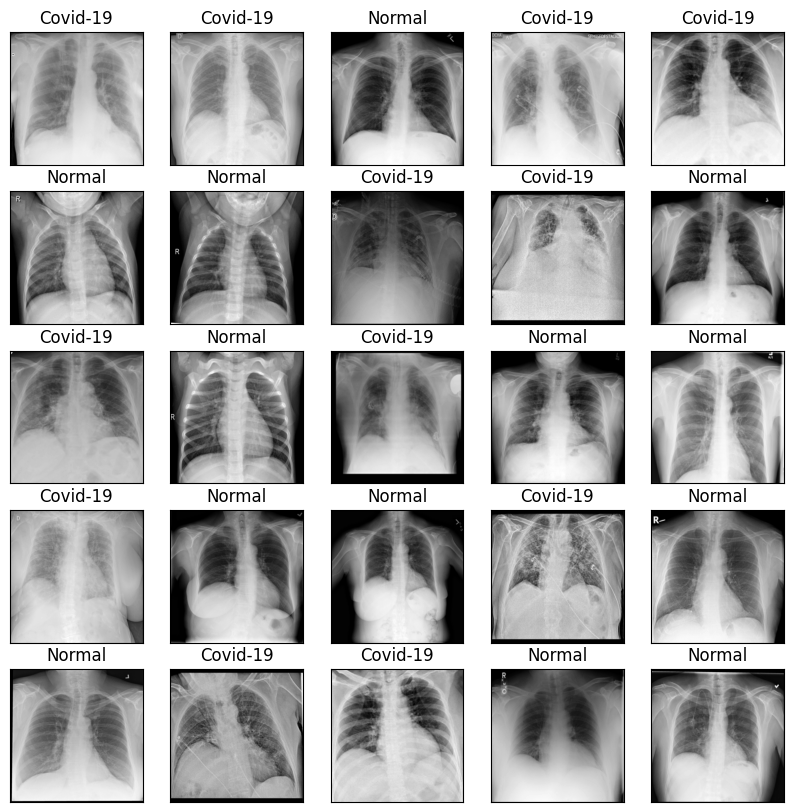

In [12]:
plt.figure(figsize=(10,10)) 
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(sample_imgs[i], cmap='gray' )
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(class_names[sample_labels[i]])
plt.show()

## Jittered labels

The labels of the validation set, jittered. These may be useful for charts similar to those in the Foundations notebooks.

In [13]:
validation_labels = np.array(list(validation_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
validation_labels.shape

(3615,)

In [14]:
jittered_validation_labels = validation_labels + (np.random.random(validation_labels.shape) * 0.8)
jittered_validation_labels.shape

(3615,)

In [15]:
test_labels = np.array(list(test_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_labels.shape

(4535,)

In [16]:
jittered_labels = test_labels + (np.random.random(test_labels.shape) * 0.8)
jittered_labels.shape

(4535,)

# Define and train a sample model

In [17]:
model = Sequential([
    layers.Flatten(input_shape=IMAGE_SIZE),
    layers.Dense(1024, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid')
])

Note that we're using **binary** cross entropy as the loss function (as there are two classes). Categorical cross-entropy is used when there are multiple classes, one-hot encoded.

In [18]:
opt = optimizers.SGD()
model.compile(optimizer=opt, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
history = model.fit(train_data,
    validation_data=validation_data,
    epochs=5)

Epoch 1/5
227/227 [==============================] - 4s 14ms/step - loss: 0.7073 - accuracy: 0.5123 - val_loss: 0.6867 - val_accuracy: 0.6467
Epoch 2/5
227/227 [==============================] - 3s 13ms/step - loss: 0.7038 - accuracy: 0.5059 - val_loss: 0.6918 - val_accuracy: 0.5264
Epoch 3/5
227/227 [==============================] - 3s 13ms/step - loss: 0.7056 - accuracy: 0.5088 - val_loss: 0.6951 - val_accuracy: 0.4733
Epoch 4/5
227/227 [==============================] - 3s 13ms/step - loss: 0.7092 - accuracy: 0.5060 - val_loss: 0.7283 - val_accuracy: 0.4736
Epoch 5/5
227/227 [==============================] - 3s 13ms/step - loss: 0.7035 - accuracy: 0.5101 - val_loss: 0.7140 - val_accuracy: 0.5264


Save and reload the model and the training history.

In [20]:
model.save('q1_sample.keras')

with open('q1_sample_history.json', 'w') as f:
    json.dump(history.history, f)

In [21]:
model = tf.keras.models.load_model('q1_sample.keras')

with open('q1_sample_history.json') as f:
    sample_history = json.load(f)

Plot the training history.

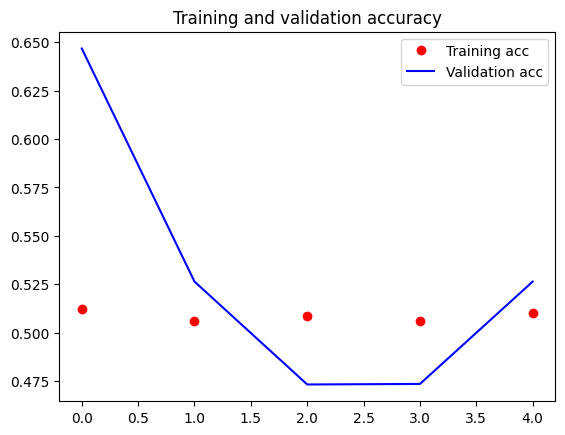

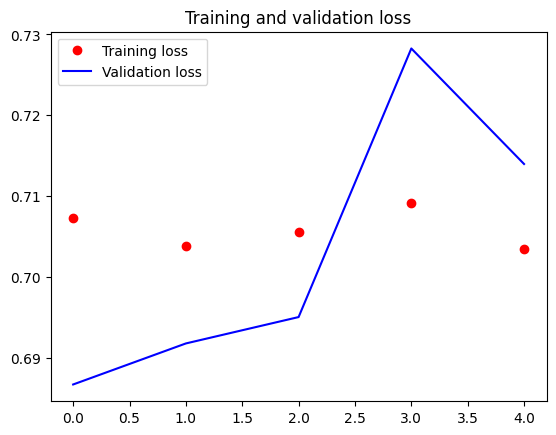

In [22]:
acc = sample_history['accuracy']
val_acc = sample_history['val_accuracy']
loss = sample_history['loss']
val_loss = sample_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Update the metrics used on the model and evaluate them on the validation data.

In [23]:
model.compile(metrics=fresh_metrics())
model.evaluate(validation_data, return_dict=True)

57/57 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - tp: 1903.0000 - fp: 1712.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.5264 - precision: 0.5264 - recall: 1.0000 - auc: 0.5038         


{'loss': 0.0,
 'tp': 1903.0,
 'fp': 1712.0,
 'tn': 0.0,
 'fn': 0.0,
 'accuracy': 0.5264177322387695,
 'precision': 0.5264177322387695,
 'recall': 1.0,
 'auc': 0.50377357006073}

# (a) Summary of Model Architecture and Input Shape Analysis

### 1. Show how many trainable parameters it has

To get the information about the model, including the number of trainable parameters,
a summary of the layers, `model.summary()`method is used. 

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 1024)              67109888  
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 67110913 (256.01 MB)
Trainable params: 67110913 (256.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Therefore, the number of trainable parameters is '67110913'. 

### 2. Show the shape of inputs to the model

In [33]:
input_shape = model.layers[0].input_shape
print("Input Shape:", input_shape)

Input Shape: (None, 256, 256, 1)


The input shape of the model is determined by the configuration of the first layer, which is accessed using `model.layers[0]`. This initial layer specifies the dimensions of the input data that the model expects, and it defines the shape as (None, 256, 256, 1),

### 3. Find the shape of the inputs and interpret it in terms of image parameters.

The input shape, represented as (None, 256, 256, 1), conveys key image parameters:

1. `None`: A dynamic placeholder for batch size, accommodating various batch sizes during training and inference.
2. `256` (Height): Denoting the image's vertical dimension in pixels.
3. `256` (Width): Signifying the image's horizontal dimension in pixels.
4. `1` (Channels): Indicates a single channel, representing grayscale images without color information.


Therefore, the input shape (None, 256, 256, 1) specifies a model configured to process image batches, each with a height and width of 256 pixels, and a single grayscale channel. The `None` dimension adapts to variable batch sizes as needed for specific tasks."

# (b) Training Modified Classifier Model

Using the sample model defined above, a new classifier model is created and trained on this dataset with the following modifications:

* Insert an additional `Dense` layer of 256 neurons between the two existing `Dense` layers
* All `Dense` layers should use sigmoid activitation
* Training should use the SGD optimiser with a learning rate of 0.001
* Remember to use `binary_crossentropy` as the loss function

The modified model is trained for 40 epochs. Plots illustrating how the accuracy and loss changed over training, for both the training and validation datasets, are displayed.


#### Create the new model with the specified modifications

In [35]:
new_model = Sequential([
    layers.Flatten(input_shape=IMAGE_SIZE),
    layers.Dense(1024, activation='sigmoid'),
    layers.Dense(256, activation='sigmoid'),  # Additional Dense layer
    layers.Dense(1, activation='sigmoid')
])


#### Compile the model with SGD optimizer and the specified learning rate(0.01)

In [37]:
new_opt = optimizers.SGD(learning_rate=0.001)
new_model.compile(optimizer=new_opt, loss='binary_crossentropy', metrics=['accuracy'])

#### Train the new model for 40 epochs

In [39]:
new_history = new_model.fit(train_data, validation_data=validation_data, epochs=40)

Epoch 1/40
227/227 [==============================] - 4s 14ms/step - loss: 0.6405 - accuracy: 0.6983 - val_loss: 0.6246 - val_accuracy: 0.7007
Epoch 2/40
227/227 [==============================] - 3s 13ms/step - loss: 0.6064 - accuracy: 0.7092 - val_loss: 0.5987 - val_accuracy: 0.7090
Epoch 3/40
227/227 [==============================] - 3s 13ms/step - loss: 0.5864 - accuracy: 0.7136 - val_loss: 0.5796 - val_accuracy: 0.7065
Epoch 4/40
227/227 [==============================] - 3s 13ms/step - loss: 0.5743 - accuracy: 0.7134 - val_loss: 0.5743 - val_accuracy: 0.7054
Epoch 5/40
227/227 [==============================] - 3s 13ms/step - loss: 0.5649 - accuracy: 0.7146 - val_loss: 0.5636 - val_accuracy: 0.7040
Epoch 6/40
227/227 [==============================] - 3s 13ms/step - loss: 0.5554 - accuracy: 0.7204 - val_loss: 0.5557 - val_accuracy: 0.7126
Epoch 7/40
227/227 [==============================] - 3s 13ms/step - loss: 0.5491 - accuracy: 0.7221 - val_loss: 0.5491 - val_accuracy: 0.7201

#### Plot the training and validation accuracy and loss for the new model

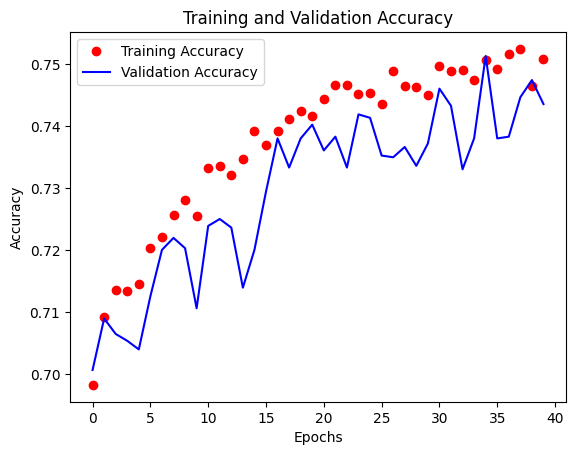

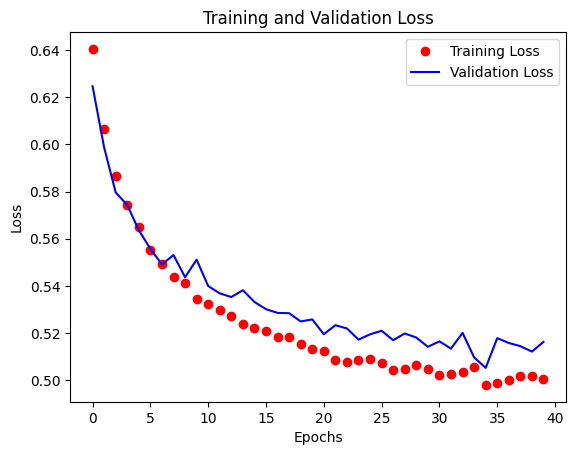

In [41]:
# Extract the training and validation history
acc = new_history.history['accuracy']
val_acc = new_history.history['val_accuracy']
loss = new_history.history['loss']
val_loss = new_history.history['val_loss']

epochs = range(len(acc))

# Plot training and validation accuracy
plt.plot(epochs, acc, 'ro', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Plot training and validation loss
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


####  Save the new model and training history

In [43]:
new_model.save('modified_covid_classifier_model_new')

# Save the training history to a JSON file
with open('modified_covid_classifier_history_new.json', 'w') as f:
    json.dump(new_history.history, f)

INFO:tensorflow:Assets written to: modified_covid_classifier_model_new/assets


INFO:tensorflow:Assets written to: modified_covid_classifier_model_new/assets


# (c) Analysis

### Comment on the plots of loss and accuracy, for both training and validation data, during the training of this model

The comparison of the loss and accuracy plots between the initial and modified models shows that the modified model has improved training dynamics. When accuracy increases and loss decreases together, it suggests better alignment and learning within the model. The modified model demonstrates a more favourable trend, indicating it fits better than the original.

Regarding the modified model, both training and validation accuracies are going up, and their losses are consistently going down. Importantly, there are no signs of problems like overfitting or the model's improvement slowing down. Therefore, it's reasonable to think that additional training could keep improving the model's performance.

# (d) (10 marks)

1. Recompile the model from part (b) above to use the metrics defined by the `fresh_metrics` function defined above. 

2. Evaluate the model, using these metrics, on all three of the **train**, **validation**, and **test** datasets. 

3. Use that model to generate predicted classes for all elements in the **test** dataset. Plot a scatter chart of the predicted results with the actual results (defined above as either `test_labels` or `jittered_labels`.)


In [17]:
new_model = tf.keras.models.load_model('modified_covid_classifier_model_new')
with open('modified_covid_classifier_history_new.json') as f:
    sample_history_2 = json.load(f)

In [18]:
# Recompile the model with fresh_metrics

new_opt = optimizers.SGD(learning_rate=0.001)
new_model.compile(optimizer=new_opt, loss='binary_crossentropy', metrics=fresh_metrics())

In [19]:
# Evaluate the model on all three datasets
train_metrics = new_model.evaluate(train_data)
validation_metrics = new_model.evaluate(validation_data)
test_metrics = new_model.evaluate(test_data)

71/71 [==============================] - 0s 5ms/step - loss: 0.5115 - tp: 1983.0000 - fp: 720.0000 - tn: 1420.0000 - fn: 412.0000 - accuracy: 0.7504 - precision: 0.7336 - recall: 0.8280 - auc: 0.8418    


In [20]:
# Generate predicted classes for the test dataset
predicted_classes = new_model.predict(test_data)

71/71 [==============================] - 0s 5ms/step


In [21]:
jittered_labels = test_labels + (np.random.random(test_labels.shape) * 0.8)
jittered_labels

array([0.26326152, 0.12849483, 0.50842029, ..., 1.64765903, 1.75165497,
       1.02624398])

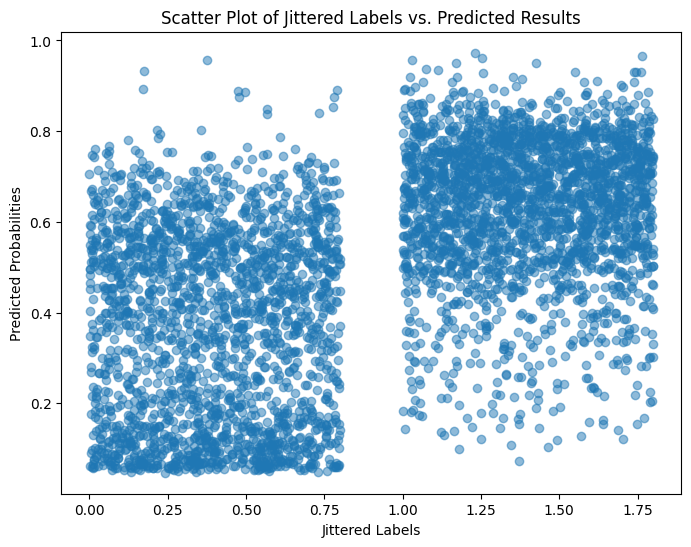

In [22]:
# Create a scatter plot of predicted results with jittered labels
plt.figure(figsize=(8, 6))
plt.scatter(jittered_labels, predicted_classes, alpha=0.5)
plt.xlabel('Jittered Labels')
plt.ylabel('Predicted Probabilities')
plt.title('Scatter Plot of Jittered Labels vs. Predicted Results')
plt.show()


#### Comment on the results

In [26]:
#First, have a look at metrics of Train Data, Validation Data and Test Data, respectively.

print("Metrics on Train Data:")
for metric_name, metric_value in zip(new_model.metrics_names, train_metrics):
    print(f"{metric_name}: {metric_value}")

Metrics on Train Data:
loss: 0.5055971741676331
tp: 6409.0
fp: 2380.0
tn: 4469.0
fn: 1249.0
accuracy: 0.7498449087142944
precision: 0.7292069792747498
recall: 0.8369025588035583
auc: 0.8437997698783875


In [27]:
print("Metrics on Validation Data:")
for metric_name, metric_value in zip(new_model.metrics_names, validation_metrics):
    print(f"{metric_name}: {metric_value}")

Metrics on Validation Data:
loss: 0.5162104368209839
tp: 1599.0
fp: 623.0
tn: 1089.0
fn: 304.0
accuracy: 0.743568480014801
precision: 0.7196219563484192
recall: 0.8402522206306458
auc: 0.8284482955932617


In [28]:
print("Metrics on Test Data:")
for metric_name, metric_value in zip(new_model.metrics_names, test_metrics):
    print(f"{metric_name}: {metric_value}")

Metrics on Test Data:
loss: 0.5115376114845276
tp: 1983.0
fp: 720.0
tn: 1420.0
fn: 412.0
accuracy: 0.7503858804702759
precision: 0.7336292862892151
recall: 0.8279749751091003
auc: 0.8418019413948059


The model consistently demonstrates strong performance across the train, validation, and test datasets, showing notable accuracy, precision, and recall metrics. Particularly, achieving recall rates exceeding 80% indicates the model's effectiveness in correctly identifying COVID-19 cases.

The AUC values, surpassing 80% across all sets, underscore the model's proficiency in distinguishing between positive and negative instances, reinforcing its overall robust performance.

Analysing the scatter plot, points clustered between 0.0 and 0.5 at the bottom suggest that the model might not consistently express strong certainty when identifying normal cases. Conversely, points around 0.8 at the top of the bands indicate a moderate level of confidence in predicting COVID-19 cases.

In conclusion, even though the model is performing well, there is still room for improvement, especially by dealing with uncertainty and improving how accurately it predicts outcomes. Adjusting further training process could result in additional enhancements, boosting the model's confidence and precision.